In [31]:
%matplotlib ipympl

In [32]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
from impedance.visualization import plot_nyquist, plot_bode
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import pandas as pd


In [33]:
#My written functions
def add_noise(z,err):
    #err is the relative SD from mean value
    z_with_noise=np.random.normal(np.real(z),err*np.abs(np.real(z)))+1j*np.random.normal(np.imag(z),err*np.abs(np.imag(z)))
    return z_with_noise

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))

def give_xylim(zin,z0):
        zin_real=np.real(zin)
        zin_imag=np.imag(zin)

        z0_real=np.real(z0)
        z0_imag=np.imag(z0)

        max_0=np.maximum(np.max(z0_real),np.max(-z0_imag))
        max_in=np.maximum(np.max(zin_real),np.max(-zin_imag))

        xylim=np.maximum(max_0,max_in)
        return xylim

def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def give_SSv(zexp,zmodel,wt,num):
    #zwt=give_weights2(zmodel,wt=wt)
    zexpr=np.real(zexp)
    zmodelr=np.real(zmodel)
    zexpj=-np.imag(zexp)
    zmodelj=-np.imag(zmodel)
    if(wt=="unit" or wt==""):
       SSv=(1/(2*len(zexp)-num))*np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
    elif(wt=="mod"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
    elif(wt=="prop"):
       SSv=(1/(2*len(zexp)-num))*np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
    return SSv

def give_SS(zexp,zmodel,wt):
     #zwt=give_weights2(zmodel,wt=wt)
     #zwt=give_weights(zmodel,wt=wt)
     zexpr=np.real(zexp)
     zmodelr=np.real(zmodel)
     zexpj=-np.imag(zexp)
     zmodelj=-np.imag(zmodel)
     if(wt=="unit" or wt==""):
       SS=np.sum((zexpr-zmodelr)**2+(zexpj-zmodelj)**2)
     elif(wt=="mod"):
       SS=np.sum(((zexpr-zmodelr)/np.abs(zmodel))**2+((zexpj-zmodelj)/np.abs(zmodel))**2)
     elif(wt=="prop"):
       SS=np.sum(((zexpr-zmodelr)/(zmodelr))**2+((zexpj-zmodelj)/(zmodelr))**2)
     return SS

In [34]:
@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlinNew(p,f):
    Rref=200
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, alpha = p[0], p[1], p[2], p[3]
    t12=t1/t2
    Q=1e-4*t2Q0/t2
    R1=Rref*t1
    S=np.sqrt((1j*omega)**alpha*R1*Q)
    kk1=-2/3*(S*(t12**(-1/2)/(t12-1)))
    kk2=-2/3*(t12*S/(t12-1))
    Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*scipy.special.iv(1/3, kk2)-scipy.special.iv(1/3, kk1)*scipy.special.iv(-1/3, kk2))
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F",""],overwrite=True)
def TLMlinzertNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))

    Z=2*(R1)*((np.exp(2*S)+1)**2
        /(eps*(S**2+0.5)*np.exp(2*S)+(-eps/4+S)*np.exp(4*S)-eps/4-S))
    
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F",""],overwrite=True)
def TLMlinsemiNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    tlin1=R1
    tlin2=R2
    t12=tlin1/tlin2
    Rion1=R1
    Rion2=R2
    wclin1=1/(Rion1*Q)
    S1=np.sqrt((1j*omega)**alpha/wclin1)
    kk=-(2/3)*t12*S1/(t12-1)

    Z = (2*R1/S1)*(scipy.special.iv(-2/3,kk)-scipy.special.iv(2/3,kk))/(scipy.special.iv(-1/3,kk)-scipy.special.iv(1/3,kk))
    
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F",""],overwrite=True)
def TLMlinsemiNewRQNormalRref(p,f):
    Rref=200
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, alpha = p[0], p[1], p[2], p[3]
    t12=t1/t2
    Q=1e-4*t2Q0/t2
    R1=Rref*t1
    S=np.sqrt((1j*omega)**alpha*R1*Q)
    kk1=-2/3*(S*(t12**(-1/2)/(t12-1)))
    kk2=-2/3*(t12*S/(t12-1))
    Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*scipy.special.iv(1/3, kk2)-scipy.special.iv(1/3, kk1)*scipy.special.iv(-1/3, kk2))
    
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinNewMix(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    t12_lin=R1/R2
    Rion1_lin=R1
    wc_lin=1/(Rion1_lin*Q)
    
    wclin_new=wc_lin*100
    idx=find_index_of_nearest(omega,wclin_new)
    omega_low=omega[0:idx]
    omega_high=omega[idx:len(omega)]

    S_lin=np.sqrt(1j*omega_low/wc_lin)
    kk1_lin=-2/3*(S_lin*(t12_lin**(-1/2)/(t12_lin-1)))   
    kk2_lin=-2/3*(t12_lin*S_lin/(t12_lin-1))

    Z_lin = (2*Rion1_lin/S_lin)*(scipy.special.iv(1/3, kk1_lin)*scipy.special.iv(2/3, kk2_lin)-scipy.special.iv(-1/3, kk1_lin)*scipy.special.iv(-2/3,kk2_lin))/((scipy.special.iv(-1/3, kk1_lin))*scipy.special.iv(1/3, kk2_lin)-scipy.special.iv(1/3, kk1_lin)*scipy.special.iv(-1/3, kk2_lin))

    #calc Z semi
    tlin1=R1
    tlin2=R2
    t12=tlin1/tlin2
    Rion1=R1
    wc_semi=1/(Rion1*Q)
    S1_semi=np.sqrt(1j*omega_high/wc_semi)
    kk=-(2/3)*t12*S1_semi/(t12-1)

    Z_semi = (2*R1/S1_semi)*(scipy.special.iv(-2/3,kk)-scipy.special.iv(2/3,kk))/(scipy.special.iv(-1/3,kk)-scipy.special.iv(1/3,kk))

    # #calc Z pert
    # tlin1=R1
    # tlin2=R2   
    # eps=(tlin2-tlin1)/tlin1
    # S_pert=np.sqrt((R1*Q*omega_high*1j))
    # Z_pert=2*(R1)*((np.exp(2*S_pert)+1)**2
    #     /(eps*(S_pert**2+0.5)*np.exp(2*S_pert)+(-eps/4+S_pert)*np.exp(4*S_pert)-eps/4-S_pert))   

    # eps_c=0.05 #i.e. 5% diff between t1 and t2
    # if eps<eps_c:
    #     Z_high=Z_pert
    # else:
    #     Z_high=Z_semi
    Z_high=Z_semi
    Z_low=Z_lin

    return np.append(Z_low,Z_high)

@element(num_params=4, units=["Ohm", "Ohm", "F",""],overwrite=True)
def TLMlinzertNewSecondFirst(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))
    
    #first expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2-S*eps+4*S**2)*np.exp(6*S)-4*S**2-S*eps+(1/8)*eps**2))
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F",""],overwrite=True)
def TLMlinzertNewSecondFirstRQNormalRref(p,f):
    omega = 2 * np.pi * np.array(f)
    t1, t2, Q0, alpha = p[0], p[1], p[2], p[3]
    Q=Q0*1e-4
    Rref=200
    R1=Rref*t1
    R2=Rref*t2
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))
    
    #first expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4+2*S**3+2*S**2+3/2*S+9/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4+2*S**3-2*S**2+3/2*S-9/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(-(1/8)*eps**2-S*eps+4*S**2)*np.exp(6*S)-4*S**2-S*eps+(1/8)*eps**2))
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlinzertNewSecondSecond(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q, alpha = p[0], p[1], p[2], p[3]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))

    #second expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4-2/3*(S**3)+2*S**2-5/2*S+1/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4-2/3*(S**3)-2*S**2-5/2*S-1/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(4*S**2-S*eps+7/8*(eps**2))*np.exp(6*S)-4*S**2-S*eps-7*eps**2*(1/8)))
    return Z

@element(num_params=4, units=["Ohm", "Ohm", "F", ""],overwrite=True)
def TLMlinzertNewSecondSecondRQNormalRref(p,f):
    
    Rref=200
    omega = 2 * np.pi * np.array(f)
    t1, t2, t2Q0, alpha = p[0], p[1], p[2], p[3]
    Q=1e-4*t2Q0/t2
    R1=Rref*t1
    eps=(t2-t1)/t1
    S=np.sqrt((R1*Q*(omega*1j)**alpha))

    #second expansion
    Z=2*4*R1*(np.exp(4*S)+2*np.exp(2*S)+1)*(np.exp(2*S)+1)*S/((((S**4-2/3*(S**3)+2*S**2-5/2*S+1/8)*eps**2+(4*S**3+S)*eps-4*S**2)*np.exp(2*S)+((-S**4-2/3*(S**3)-2*S**2-5/2*S-1/8)*eps**2+(4*S**3+S)*eps+4*S**2)*np.exp(4*S)+(4*S**2-S*eps+7/8*(eps**2))*np.exp(6*S)-4*S**2-S*eps-7*eps**2*(1/8)))
    return Z

In [35]:
def plotter_for_lin(freq,circuit0,zin1,zin2,zin3,circuitg1,circuitg2,circuitg3,wt):
    
    Rref=200
    c0=circuit0
    z0=c0.predict(freq)
    cg1=circuitg1
    cg2=circuitg2
    cg3=circuitg3
    cf1=cg1.fit(freq,zin1,sigma=give_weights(zin1,wt),bounds=([1,1,0,0],[np.inf,np.inf,np.inf,1]))
    #print(cf1)
    cf2=cg2.fit(freq,zin2,sigma=give_weights(zin2,wt),bounds=([1,1,0,0],[np.inf,np.inf,np.inf,1]))
    cf3=cg3.fit(freq,zin3,sigma=give_weights(zin3,wt),bounds=([1,1,0,0],[np.inf,np.inf,np.inf,1]))
    #print(cg3)

    zf1=cf1.predict(freq)
    zf2=cf2.predict(freq)
    zf3=cf3.predict(freq)


    #Rj_i means tj_i
    #Q_i means Q0_i
    
    p0=c0.initial_guess
    t1_0=p0[0]
    t2_0=p0[1]
    t2Q0_0=p0[2]
    alpha_0=p0[3]
    Q_0=1e-4*t2Q0_0/t2_0

    pg=cg1.initial_guess
    t1_g=pg[0]
    t2_g=pg[1]
    t2Q0_g=pg[2]
    alpha_g=pg[3]
    Q_g=1e-4*t2Q0_g/t2_g

    pf1=cg1.parameters_
    t1_f1=pf1[0]
    t2_f1=pf1[1]
    t2Q0_f1=pf1[2]
    alpha_f1=pf1[3]
    Q_f1=1e-4*t2Q0_f1/t2_f1


    pf2=cg2.parameters_
    t1_f2=pf2[0]
    t2_f2=pf2[1]
    t2Q0_f2=pf2[2]
    alpha_f2=pf2[3]
    Q_f2=1e-4*t2Q0_f2/t2_f2

    pf3=cf3.parameters_
    t1_f3=pf3[0]
    t2_f3=pf3[1]
    t2Q0_f3=pf3[2]
    alpha_f3=pf3[3]
    Q_f3=1e-4*t2Q0_f3/t2_f3

    linewidth=1
    linewidth_actual=1
    ticksize=6
    color_actual="red"
    color_noise1=[0,0.5,0]
    color_noise2=[0.2,0.4,0.2]
    color_noise3=[0,0.65,0.4]
    color_fitted1=[0,0,1]
    color_fitted2=[0.4,0.58,0.65]
    color_fitted3=[0,0.6,1]

    fig = plt.figure(f"Results at")
    fig.set_size_inches(10,6)
    
    #profile fit and profile original
    ax1=plt.subplot2grid((5,4),(1,0),rowspan=2,colspan=2)
    #ax1= fig.add_subplot(2,4,1)
    ax1.plot([0,1],[t1_f1,t2_f1],linewidth=linewidth,color=color_fitted1,label="Fitted 1")
    ax1.plot([0,1],[t1_f2,t2_f2],linewidth=linewidth,color=color_fitted2,label="Fitted 2")
    ax1.plot([0,1],[t1_f3,t2_f3],linewidth=linewidth,color=color_fitted3,label="Fitted 3")
    ax1.plot([0,1],[t1_0,t2_0],linewidth=linewidth_actual,color=color_actual,label="Actual")
    ax1.tick_params(labelsize=ticksize)
    ax1.text(-0.1, 1.1, "(A)", transform=ax1.transAxes, size=10, weight='bold')
    ax1.grid(visible=True)
    # ax1.axvline(x=delta_0,ls="--",linewidth=0.6,color=color_actual)
    # ax1.axvline(x=delta_f1,ls="--",linewidth=0.6,color=color_fitted1)
    # ax1.axvline(x=delta_f2,ls="--",linewidth=0.6,color=color_fitted2)
    # ax1.axvline(x=delta_f3,ls="--",linewidth=0.6,color=color_fitted3)
    ax1.set_ylabel("τ1 / τ2 (Ω)") 
    ax1.set_xlabel("δ")
    ax1.set_xmargin(0)
    leg=ax1.legend()
    for line in leg.get_lines():
        line.set_linewidth(3)

    xylim=max(give_xylim(zin1,zf1),give_xylim(zin1,z0))

    if xylim%1000>=1:
        units="kΩ"
        factor=1000
    else:
        units="Ω"
        factor=1

    alpha=0.3
    #nyquist plot 
    #ax2=fig.add_subplot(1,2,2)
    ax2=plt.subplot2grid((5,4),(1,2),colspan=2,rowspan=4)
    ax2.text(-0.1, 1.05, "(B)", transform=ax2.transAxes, size=10, weight='bold')
    ax2.set_xlim(-0.2*xylim/factor,xylim/factor)
    ax2.set_ylim(-0.2*xylim/factor,xylim/factor)
    plot_nyquist(zin1/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf2/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(zf3/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_nyquist(z0/factor,ax=ax2,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    #inset_for_nyquist_plo

    ax2_inset=ax2.inset_axes(bounds=[0.4,0.1,0.5,0.5])
    plot_nyquist(zin1/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zin2/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zin3/factor,ax=ax2_inset,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=alpha)
    plot_nyquist(zf1/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)
    idx=find_index_of_nearest(freq,f_c)
    z_c=c0.predict([freq[idx]])

    xylim_inset=1.2*np.real(z_c)
    ax2_inset.set_xlim(0,xylim_inset/factor)
    ax2_inset.set_ylim(0,xylim_inset/factor)
    ax2_inset.set_xlabel("")
    ax2_inset.set_ylabel("")
    ax2.indicate_inset_zoom(ax2_inset)

    ax2_inset1=ax2.inset_axes(bounds=[0.4,0.7,0.3,0.2])
    plot_nyquist(zin1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize)
    plot_nyquist(zin2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize)
    plot_nyquist(zin3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize)
    plot_nyquist(zf1/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf2/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)    
    
    plot_nyquist(zf3/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)    
    plot_nyquist(z0/factor,ax=ax2_inset1,units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)
    
    f_c=1/(Rref*t1_0*Q_0)

    f_c=freq[len(freq)-1]*2
    idx=find_index_of_nearest(freq,f_c)
    z0c=c0.predict([freq[idx]])
    zfc1=cf1.predict([freq[idx]])
    zfc2=cf2.predict([freq[idx]])
    zfc3=cf3.predict([freq[idx]])
    
    max_xlim_inset=np.max([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    max_ylim_inset=np.max([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    min_xlim_inset=np.min([np.real(z0c),np.real(zfc1),np.real(zfc2),np.real(zfc3)])
    min_ylim_inset=np.min([-np.imag(z0c),-np.imag(zfc1),-np.imag(zfc2),-np.imag(zfc3)])
    gap=(max_xlim_inset-min_xlim_inset)/factor
    print(gap)
    # ax2_inset1.set_xlim(xlim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_ylim(ylim_inset/factor,1.01*xlim_inset/factor)
    # ax2_inset1.set_xlim(min_xlim_inset/factor-0.1*max_xlim_inset/factor,1.1*max_xlim_inset/factor)
    # ax2_inset1.set_ylim(min_ylim_inset/factor-0.1*max_xlim_inset/factor,min_ylim_inset/factor+0.1*max_xlim_inset/factor)
    
    ax2_inset1.set_xlim(min_xlim_inset/factor-2*gap,2*gap+max_xlim_inset/factor)
    ax2_inset1.set_ylim(min_ylim_inset/factor-2*gap,min_ylim_inset/factor+2*gap)
    ax2_inset1.set_aspect("equal")
    ax2_inset1.set_xlabel("")
    ax2_inset1.set_ylabel("")
    ax2_inset1.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2_inset1.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax2.indicate_inset_zoom(ax2_inset1)
    #bode plots
    #ax3a=fig.add_subplot(2,4,5)
    #ax3b=fig.add_subplot(2,4,6)
    ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
    ax3b.text(-0.1, 1.1, "(D)", transform=ax3b.transAxes, size=10, weight='bold')
    plot_bode(freq,zin1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise1,ms=2,ticksize=ticksize,alpha=alpha)
    plot_bode(freq,zin2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise2,ms=2,ticksize=ticksize,alpha=alpha)
    plot_bode(freq,zin3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt=".",color=color_noise3,ms=2,ticksize=ticksize,alpha=alpha)
    plot_bode(freq,zf1/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted1,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf2/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted2,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,zf3/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_fitted3,linewidth=linewidth,ticksize=ticksize)
    plot_bode(freq,z0/factor,axes=[ax3a,ax3b],units=units,labelsize=10,fmt="",color=color_actual,linewidth=linewidth,ticksize=ticksize)

    ax3a.clear()
    ax3a.text(-0.1, 1.1, "(C)", transform=ax3a.transAxes, size=10, weight='bold')
    dip_angle=np.min(-np.angle((np.hstack((zf1,zf2,zf3))),deg=True))
    angle_z0=-np.angle(z0,deg=True)

    idx=find_index_of_nearest(angle_z0,dip_angle)
    angle_z1=-np.angle(zf1,deg=True)
    angle_z2=-np.angle(zf2,deg=True)
    angle_z3=-np.angle(zf3,deg=True)
    
    print("dip_angle",dip_angle)
    ax3a.plot(freq,angle_z1,color=color_fitted1)
    ax3a.plot(freq,angle_z3,color=color_fitted2)
    ax3a.plot(freq,angle_z2,color=color_fitted3)
    ax3a.plot(freq,angle_z0,color=color_actual,linewidth=0.5)
    
    ax3a.set_xlabel('f [Hz]', fontsize=10)
    ax3a.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10)
    ax3a.set_xlim(freq[idx]/50,freq[0])
    ax3a.set_ylim(angle_z0[idx]-5,angle_z0[idx]+10)
    ax3a.set_xscale('log')
    ax3a.grid(visible=True)

    # percent_err1=(p0-pf1)*100/(p0)
    # percent_err2=(p0-pf2)*100/(p0)
    # percent_err3=(p0-pf3)*100/(p0)
    SSv1=give_SSv(zin1,zf1,wt,4)
    SSv2=give_SSv(zin2,zf2,wt,4)
    SSv3=give_SSv(zin3,zf3,wt,4)
    
    SS1=give_SS(zin1,zf1,wt)
    SS2=give_SS(zin2,zf2,wt)
    SS3=give_SS(zin3,zf3,wt)

    p0_table=np.array([t1_0,t2_0,Q_0,alpha_0,0,0])
    pf1_table=np.array([t1_f1,t2_f1,Q_f1,alpha_f1,SS1,SSv1])
    pf2_table=np.array([t1_f2,t2_f2,Q_f2,alpha_f2,SS2,SSv2])
    pf3_table=np.array([t1_f3,t2_f3,Q_f3,alpha_f3,SS3,SSv3])
    pg_table=np.array([t1_g,t2_g,Q_g,alpha_g])
    
    percent_err1=(pf1_table-p0_table)*100/(p0_table)
    percent_err2=(pf2_table-p0_table)*100/(p0_table)
    percent_err3=(pf3_table-p0_table)*100/(p0_table)

    percent_err_table1=percent_err1
    percent_err_table2=percent_err2
    percent_err_table3=percent_err3

    sd1=cf1.conf_
    sd2=cf2.conf_
    sd3=cf3.conf_
    p0_table2=[t1_0,t2_0,t2Q0_0,alpha_0]
    pf1_table2=[t1_f1,t2_f1,t2Q0_f1,alpha_f1]
    sd1_table2=sd1
    pf2_table2=[t1_f2,t2_f2,t2Q0_f2,alpha_f2]
    sd2_table2=sd2
    pf3_table2=[t1_f3,t2_f3,t2Q0_f3,alpha_f3]
    sd3_table2=sd3
    pg_table2=[t1_g,t2_g,t2Q0_g,alpha_g]
    def make_values_for_table(arr):
        for i in range(0,len(arr)):
            arr[i]="{:.2e}".format(arr[i])
        return arr
    
    pf1_table=make_values_for_table(pf1_table)
    pf2_table=make_values_for_table(pf2_table)
    pf3_table=make_values_for_table(pf3_table)
    p0_table=make_values_for_table(p0_table)
    pg_table=make_values_for_table(pg_table)
    percent_err_table1=make_values_for_table(percent_err_table1)
    percent_err_table2=make_values_for_table(percent_err_table2)
    percent_err_table3=make_values_for_table(percent_err_table3)

    data =np.array([p0_table,pf1_table,percent_err_table1,pf2_table,percent_err_table2,pf3_table,percent_err_table3])
    #cell_colors=[["blue","blue","blue","blue"],["green","green","green","green"]]
    
    pf1_table2=make_values_for_table(pf1_table2)
    pf2_table2=make_values_for_table(pf2_table2)
    pf3_table2=make_values_for_table(pf3_table2)
    p0_table2=make_values_for_table(p0_table2)
    pg_table2=make_values_for_table(pg_table2)
    sd1_table2=make_values_for_table(sd1_table2)
    sd2_table2=make_values_for_table(sd2_table2)
    sd3_table2=make_values_for_table(sd3_table2)
    
    data2=np.array([p0_table2,pf1_table2,sd1_table2,pf2_table2,sd2_table2,pf3_table2,sd3_table2])
    
    ax4=plt.subplot2grid((5,4),(0,0),colspan=4,rowspan=1)
    ax4.set_axis_off()
    colwidth=np.full((8),0.1)
    #pm_table=ax4.table(np.transpose(data),colLabels=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],colWidths=colwidth,rowLabels=["τ1","τ2","Q","α","SS","SSv"],loc="center") 
    #pm_table.auto_set_font_size(False)
    #pm_table.set_fontsize(8)

    pm_table_df=pd.DataFrame(np.transpose(data),columns=["Actual","Fitted 1","% Error","Fitted 2","% Error","Fitted 3","% Error"],index=["τ1","τ2","Q","α","SS","SSv"])

    pm_table_df2=pd.DataFrame(np.transpose(data2),columns=["Actual","Fitted 1","SD","Fitted 2","SD","Fitted 3","SD"],index=["τ1","τ2","τ2Q0","α"])

    with pd.ExcelWriter(f"Error t1={t1_0} t2={t2_0}.xlsx",mode="w",) as writer:
        pm_table_df.to_excel(writer)
    
    with pd.ExcelWriter(f"SD t1={t1_0} t2={t2_0}.xlsx",mode="w",) as writer:
        pm_table_df2.to_excel(writer)

    fig.tight_layout(pad=0.5)



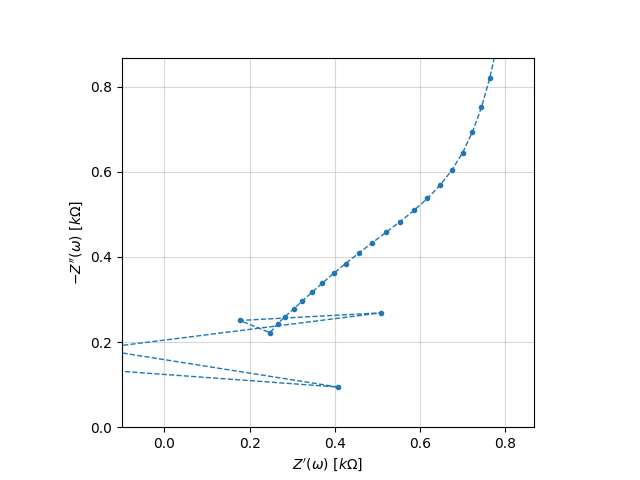

In [41]:
c0=CustomCircuit(initial_guess=[6,5,1,0.95],circuit='TLMlinNew')
freq = np.logspace(3,-3,num=100)
z0 = c0.predict(freq)
fig2, ax34= plt.subplots()

xylim=max(give_xylim(z0,z0),give_xylim(z0,z0))
if xylim%1000>=1:
    units="kΩ"
    factor=1000
else:
    units="Ω"
    factor=1
dcdc=c0.initial_guess
t1_0=dcdc[0]
t2_0=dcdc[1]
Q_0=1e-4*dcdc[2]/dcdc[1]
Rref=200
f_c=1/(Rref*t1_0*Q_0)
idx=find_index_of_nearest(freq,f_c)
z_c=c0.predict([freq[idx]])
xylim_inset=1.2*np.real(z_c)
ax34.set_xlim(-0.1,xylim_inset/factor)
ax34.set_ylim(0,xylim_inset/factor)
plot_nyquist(z0/factor,ax=ax34,units=units,labelsize=10,linestyle="--",marker="o",ms=3,linewidth=1,label="Normal Precision") 
plt.savefig(f"t1={t1_0} t2={t2_0}.png",format="png")
plt.show()


In [37]:
param_guess=[6,2,1,0.95]
cg1=CustomCircuit(initial_guess=param_guess,circuit='TLMlinNew')
cg2=CustomCircuit(initial_guess=param_guess,circuit='TLMlinNew')
cg3=CustomCircuit(initial_guess=param_guess,circuit='TLMlinNew')

z1=add_noise(z0,0.05)
z2=add_noise(z0,0.05)
z3=add_noise(z0,0.05)

C:\Users\admin\AppData\Local\Temp\ipykernel_27376\1821781932.py:12: RuntimeWarning: invalid value encountered in divide
  Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*scipy.special.iv(1/3, kk2)-scipy.special.iv(1/3, kk1)*scipy.special.iv(-1/3, kk2))
C:\Users\admin\AppData\Local\Temp\ipykernel_27376\1821781932.py:12: RuntimeWarning: divide by zero encountered in divide
  Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*scipy.special.iv(1/3, kk2)-scipy.special.iv(1/3, kk1)*scipy.special.iv(-1/3, kk2))
C:\Users\admin\AppData\Local\Temp\ipykernel_27376\1821781932.py:12: RuntimeWarning: overflow encountered in multiply
  Z = (2*R1/S)*(scipy.special.iv(1/3, kk1)*scipy.special.iv(2/3, kk2)-scipy.special.iv(-1/3, kk1)*scipy.special.iv(-2/3, kk2))/((scipy.special.iv(-1/3, kk1))*sc

4.489368321530812
dip_angle 40.33975407282954


C:\Users\admin\AppData\Local\Temp\ipykernel_27376\444080592.py:183: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3a=plt.subplot2grid((5,4),(3,0),colspan=1,rowspan=2)
C:\Users\admin\AppData\Local\Temp\ipykernel_27376\444080592.py:185: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3b=plt.subplot2grid((5,4),(3,1),colspan=1,rowspan=2)
C:\Users\admin\AppData\Local\Temp\ipykernel_27376\444080592.py:235: RuntimeWarning: divide by zero encountered in divide
  percent_err1=(pf1_table-p0_table)*100/(p0_table)
C:\Users\admin\AppData\Local\Temp\ipykernel_27376\444080592.py:236: RuntimeWarning: divide by zero encountered in divide
  percent_err2=(pf2_table-p0_table)*100/(p0_table)
C:\Users\admin\AppData\Local\Temp\ipykernel_27376\444080592.py

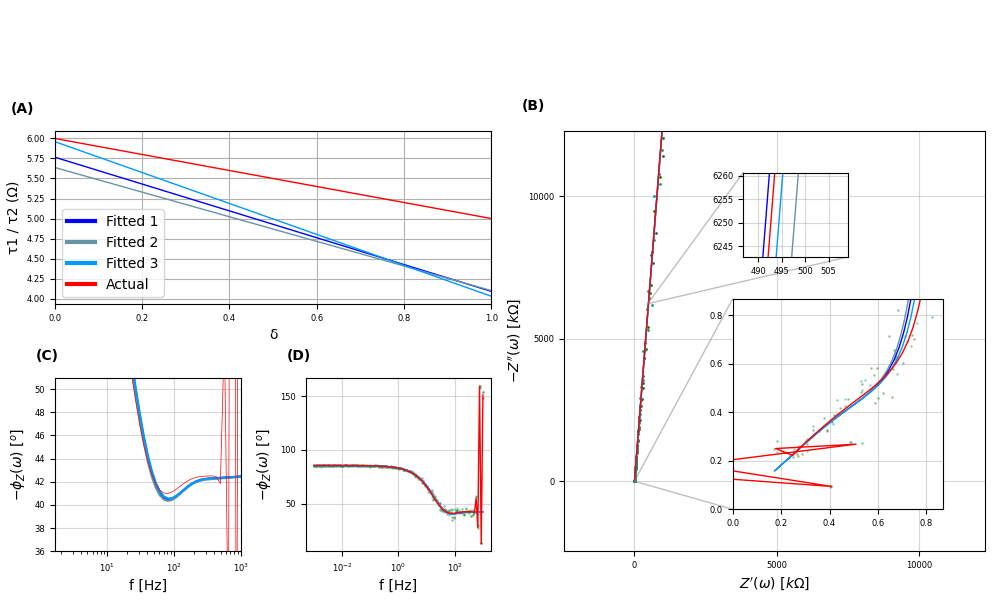

In [38]:
plotter_for_lin(freq,circuit0=c0,zin1=z1,zin2=z2,zin3=z3,circuitg1=cg1,circuitg2=cg2,circuitg3=cg3,wt="prop")
plt.show()

In [39]:
initial_guess=[1.1,1,6.61e-4]
tlmlin=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinNew_0')
tlmlin_zert=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinzertNew_0')
tlmlin_semi=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinsemiNew_0')
tlmlin_mix=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinNewMix_0')
tlmlin_zert_21=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinzertNewSecondFirst')
tlmlin_zert_22=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinzertNewSecondSecond')


ValueError: The number of initial guesses (3) + the number of constants (0) must be equal to the circuit length (4)

In [ ]:
##just code to check plotting from diff freq ranges
# f_pred_c=1/(2*np.pi*194.56*4*6.61e-4)
# f_pred_c_lin_new=f_pred_c*10
# idx=find_index_of_nearest(f_pred,f_pred_c_lin_new)
# f_low=f_pred[0:idx]
# f_high=f_pred[idx:len(f_pred)]

#printing the f_pred, high and low
#print(f_pred,f_low,f_high)

In [ ]:
f_pred = np.logspace(-3,3,num=50)

tlmlin_pred = tlmlin.predict(f_pred)
tlmlin_zert_pred=tlmlin_zert.predict(f_pred)
tlmlin_semi_pred=tlmlin_semi.predict(f_pred)
tlmlin_mix_pred=tlmlin_mix.predict(f_pred)
tlmlin_zert_21_pred=tlmlin_zert_21.predict(f_pred)
tlmlin_zert_22_pred=tlmlin_zert_22.predict(f_pred)

NameError: name 'tlmlin' is not defined

In [ ]:
# ax= plt.figure().add_subplot()
# # factor=194.56/1.5
# factor=1
# ax.plot(np.real(tlmlin_pred/factor),-np.imag(tlmlin_pred/factor),"r",label="lin")
# ax.plot(np.real(tlmlin_zert_pred/factor),-np.imag(tlmlin_zert_pred/factor),"b",label="lin_pert")
# #ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
# #ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
# ax.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
# ax.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")
# ax.legend()
# ax.set_xlabel("Re(Z)")
# ax.set_ylabel("-Im(Z)")
# ax.set_aspect("equal")
# ax.set_xlim(-4,200)
# ax.set_ylim(-1,200)

In [ ]:
def give_chi_square(z1,z2):
    return np.sum((np.real(z1)-np.real(z2))**2), np.sum((np.imag(z1)-np.imag(z2))**2)

In [ ]:
# print(give_chi_square(tlmlin_pred,tlmlin_zert_pred))
# print(give_chi_square(tlmlin_zert_21_pred,tlmlin_zert_22_pred))
# tlmlin_zert_pred
#tlmlin_zert_pred

In [ ]:
def make_z_from_csv(filename):
    data_csv=np.genfromtxt(filename,delimiter=',')
    zz=data_csv[0]+1j*data_csv[1]
    return zz


In [ ]:
# z_lin_maple_100=make_z_from_csv("z_lin_data.csv")
# z_lin_pert_maple_100=make_z_from_csv("z_lin_pert_data.csv")
# z_lin_pert_21_maple_100=make_z_from_csv("z_lin_pert_21_data.csv")
# z_lin_pert_22_maple_100=make_z_from_csv("z_lin_pert_22_data.csv")

In [ ]:
# z_lin_maple_100_100=make_z_from_csv("z_lin_data_R1R2_100.csv")
# z_lin_pert_maple_100_100=make_z_from_csv("z_lin_pert_data_R1R2_100.csv")
# z_lin_pert_21_maple_100_100=make_z_from_csv("z_lin_pert_21_data_R1R2_100.csv")
# z_lin_pert_22_maple_100_100=make_z_from_csv("z_lin_pert_22_data_R1R2_100.csv")

In [ ]:
# z_lin_maple_100_1_point_1=make_z_from_csv("z_lin_data_100_R1R2_1point1.csv")
# z_lin_pert_maple_100_1_point_1=make_z_from_csv("z_lin_pert_data_100_R1R2_1point1.csv")
# z_lin_pert_21_maple_100_1_point_1=make_z_from_csv("z_lin_pert_21_data_100_R1R2_1point1.csv")
# z_lin_pert_22_maple_100_1_point_1=make_z_from_csv("z_lin_pert_22_data_100_R1R2_1point1.csv")

NameError: name 'tlmlin_pred' is not defined

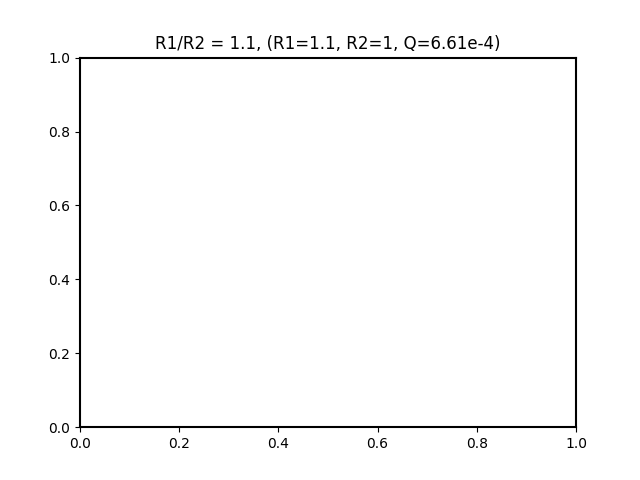

In [ ]:
plt.rcParams['axes.linewidth'] = 1.5
ax= plt.figure().add_subplot()
ax.set_title("R1/R2 = 1.1, (R1=1.1, R2=1, Q=6.61e-4)")
# # factor=194.56/1.5
factor=1
ax.plot(np.real(tlmlin_pred/factor),-np.imag(tlmlin_pred/factor),"r",label="lin")
ax.plot(np.real(tlmlin_zert_pred/factor),-np.imag(tlmlin_zert_pred/factor),"b",label="lin_pert")
#ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
#ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
ax.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
ax.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")
#ax.legend(loc="upper center",ncol=4,bbox_to_anchor=[0.5,-0.14])
ax.legend(loc="upper center")
ax.set_xlabel("Re(Z)")
ax.set_ylabel("-Im(Z)")
ax.set_aspect("equal")
ax.set_xlim(0.4,3.6)
ax.set_ylim(0.6,3.6)
plt.rcParams['axes.linewidth'] = 1

ax11=ax.inset_axes(bounds=[0.24,0.25,0.37,0.4])
#ax.indicate_inset_zoom(ax11)
ax11.set_title("High ω")
ax11.set_xlim(0.64,0.65)
ax11.set_ylim(0.660,0.665)
ax11.set_aspect("equal")
ax11.plot(np.real(tlmlin_pred/factor),-np.imag(tlmlin_pred/factor),"r",label="lin")
ax11.plot(np.real(tlmlin_zert_pred/factor),-np.imag(tlmlin_zert_pred/factor),"b",label="lin_pert")
#ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
#ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
ax11.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
ax11.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")

ax12=ax.inset_axes(bounds=[0.64,0.07,0.6,0.8])
ax12.set_title("Low ω")
#ax.indicate_inset_zoom(ax12)
ax12.set_xlim(0.711,0.713)
ax12.set_ylim(2,2.005)
ax12.set_aspect("equal")
ax12.plot(np.real(tlmlin_pred/factor),-np.imag(tlmlin_pred/factor),"r",label="lin")
ax12.plot(np.real(tlmlin_zert_pred/factor),-np.imag(tlmlin_zert_pred/factor),"b",label="lin_pert")
#ax.plot(np.real(tlmlin_semi_pred)/factor,-np.imag(tlmlin_semi_pred)/factor,"g",label="lin_semi")
#ax.plot(np.real(tlmlin_mix_pred)/factor,-np.imag(tlmlin_mix_pred)/factor,"y",label="lin_mix")
ax12.plot(np.real(tlmlin_zert_21_pred)/factor,-np.imag(tlmlin_zert_21_pred)/factor,"pink",label="lin_pert_21")
ax12.plot(np.real(tlmlin_zert_22_pred)/factor,-np.imag(tlmlin_zert_22_pred)/factor,"g",label="lin_pert_22")

plt.savefig("Pert 2nd oder small R1 R2 diff.svg",format="svg")
##From MAPLE
# ax4= plt.figure().add_subplot()
# ax4.set_title("Maple R1/R2 = 100, Digits=100")
# ax4.plot(np.real(z_lin_maple_100_100),-np.imag(z_lin_maple_100_100),"r",label="lin")
# ax4.plot(np.real(z_lin_pert_maple_100_100),-np.imag(z_lin_pert_maple_100_100),"b",label="lin_pert")
# ax4.plot(np.real(z_lin_pert_21_maple_100_100),-np.imag(z_lin_pert_21_maple_100_100),"pink",label="lin_pert_21")
# ax4.plot(np.real(z_lin_pert_22_maple_100_100),-np.imag(z_lin_pert_22_maple_100_100),"g",label="lin_pert_22")
# ax4.legend()
# ax4.set_xlabel("Re(Z)")
# ax4.set_ylabel("-Im(Z)")
# ax4.set_aspect("equal")
# ax4.set_xlim(0,200)
# ax4.set_ylim(0,300)

# ax6= plt.figure().add_subplot()
# ax6.set_title("maple_100_100_rerun")
# ax6.plot(np.real(z_lin_maple_100_100),-np.imag(z_lin_maple_100_100),"r",label="lin")
# ax6.plot(np.real(z_lin_pert_maple_100_100),-np.imag(z_lin_pert_maple_100_100),"b",label="lin_pert")
# ax6.plot(np.real(z_lin_pert_21_maple_100_100),-np.imag(z_lin_pert_21_maple_100_100),"pink",label="lin_pert_21")
# #ax6.plot(np.real(z_lin_pert_22_maple_100_100),-np.imag(z_lin_pert_22_maple_100_100),"g",label="lin_pert_22")
# ax6.legend()
# ax6.set_xlabel("Re(Z)")
# ax6.set_ylabel("-Im(Z)")
# ax6.set_aspect("equal")
# ax6.set_xlim(-4,200)
# ax6.set_ylim(-1,600)

# ax5= plt.figure().add_subplot()
# ax5.set_title("Maple R1/R2 = 1.1, Digits=100")
# ax5.plot(np.real(z_lin_maple_100_1_point_1),-np.imag(z_lin_maple_100_1_point_1),"r",label="lin")
# ax5.plot(np.real(z_lin_pert_maple_100_1_point_1),-np.imag(z_lin_pert_maple_100_1_point_1),"b",label="lin_pert")
# ax5.plot(np.real(z_lin_pert_21_maple_100_1_point_1),-np.imag(z_lin_pert_21_maple_100_1_point_1),"pink",label="lin_pert_21")
# ax5.plot(np.real(z_lin_pert_22_maple_100_1_point_1),-np.imag(z_lin_pert_22_maple_100_1_point_1),"g",label="lin_pert_22")
# ax5.legend()
# ax5.set_xlabel("Re(Z)")
# ax5.set_ylabel("-Im(Z)")
# ax5.set_aspect("equal")
# ax5.set_xlim(0.5,0.8)
# ax5.set_ylim(0.5,1.5)


In [ ]:
give_chi_square(z_lin_maple_100_1_point_1,z_lin_pert_maple_100_1_point_1)
print(z_lin_maple_100_1_point_1)

[       nan           +nanj 0.71666667-3.82515174e+05j
 0.71666667-3.03842603e+05j ... 0.68465076-8.85908384e-01j
 0.66794383-7.54930525e-01j        nan           +nanj]
